In [13]:
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm


In [14]:
model = "1_0_0_0_0_5"

experiment_paths = [
    Path(p)
    for p in (
        "../data/20220224/",
        "../data/20220307/",
        "../data/20220312/",
        "../data/20220314/",
        "../data/20220316/",
        "../data/20220331-1/",
        "../data/20220331-2/",
        "../data/20220427-1/",
        "../data/20220427-2/",
        "../data/20220513-1/",
        "../data/20220513-2/",
        "../data/20220513-3/",
        "../data/20220513-4/",
        "../data/20220513-5/",
        "../data/20220513-6/",
        "../data/20220525-1/",
        "../data/20220525-2/",
        "../data/20220622-1/",
        "../data/20220622-2/",
        "../data/20220630-1/",
        "../data/20220630-2/",
        "../data/20220711-1/",
        "../data/20220711-2/",
        "../data/20221103-1/",
        "../data/20221103-2/",
        "../data/20221103-3/",
        "../data/20221109-1/",
        "../data/20221109-2/",
        "../data/20221109-3/",
        "../data/20221110/",
        "../data/20221116-1/",
        "../data/20221123/",
        "../data/20221124/",
        "../data/20221129-1/",
        "../data/20221129-2/",
        "../data/20221129-3/",
        "../data/20221129-4/",
        "../data/20221129-5/",
        "../data/20221205-1/",
        "../data/20221205-2/",
        "../data/20221205-3/",
    )
]



In [15]:
models = {
    "Instrument": "1_0_0_0_0",
    "Tilt": "1_1_0_0_0",
    "Atmospheric": "1_0_1_0_0",
    "Extrinsic": "1_0_0_1_0",
    "Time": "1_0_0_0_1",
    "All": "1_1_1_1_1",
}
columns=["time", "mx", "my", "mz"] + [f"Sp{i}" for i in range(9)] + ["r", "p", "y"] + [f"Sa{i}" for i in range(9)]
orig_dfs = {mname: {} for mname in models.keys()}
orig_dfs = {"P1":{}, "P2":{}, "P3":{}, **orig_dfs}
ignored_dates = ["20220513-5","20220711-1", "20221124", "20221129-4", "20221205-2"]
for pat in tqdm(experiment_paths):
    uncertainty_data = pat / "uncertainty"
    sensor_data = uncertainty_data / "sensor"
    prism_data = uncertainty_data / "interpolation"
    date = str(pat.stem)
    for mname, mcode in models.items():
        GNSS_path = sensor_data / f"GNSS_{mcode}_0.csv"
        if GNSS_path.exists() and not date in ignored_dates:
            orig_dfs[mname][date] = pd.read_csv(GNSS_path, sep=" ", names=columns, header=None)
    if not date in ignored_dates:
        orig_dfs["P1"][date] = pd.read_csv(prism_data / f"MC_Fake_{model}_1.csv", sep=" ", names=columns, header=None)
        orig_dfs["P2"][date] = pd.read_csv(prism_data / f"MC_Fake_{model}_2.csv", sep=" ", names=columns, header=None)
        orig_dfs["P3"][date] = pd.read_csv(prism_data / f"MC_Fake_{model}_3.csv", sep=" ", names=columns, header=None)

100%|██████████| 41/41 [00:10<00:00,  3.94it/s]


In [19]:
dist_dfs = {mname: {} for mname in models.keys()}
columns=["time", "d12", "d13", "d23"]
ignored_dates = ["20220513-5", "20220711-1", "20221124", "20221129-4", "20221205-2"]
for path in tqdm(experiment_paths):
    uncertainty_data = pat / "uncertainty"
    sensor_data = uncertainty_data / "sensor"
    date = str(pat.stem)
    for mname, mcode in models.items():
        dist_path = sensor_data / f"GNSS_DIST_{mcode}_0.csv"
        if not date in ignored_dates:
            dist_dfs[mname][date] = pd.read_csv(
                GNSS_path, sep=" ", names=columns, header=None
            )


100%|██████████| 41/41 [00:04<00:00,  9.90it/s]


In [21]:
concat_dfs = {l:pd.concat(df.values(), ignore_index=True) for l, df in orig_dfs.items()}
begin, end = 1000, 1020
cutted_dfs = {l: df.iloc[begin:end].copy() for l, df in concat_dfs.items()}

concat_dists = {l:pd.concat(df.values(), ignore_index=True) for l, df in dist_dfs.items()}

{'Instrument': {'20221205-3':                                                                                                                                                                                                                     time  \
-78.457577  -78.666000  47.147047 0.431697 0.558173 -0.131678  0.259827 -0.131678 0.034723 -0.061184  0.259827 -0.061184 0.120952 2.071199 -0.186323 -0.338089 0.118303 -0.318847  0.461751 -0.318847 1.245829 -2.036739   
-78.685040  -78.781972  47.305321 0.369008 0.536253 -0.112059  0.263370 -0.112059 0.067030 -0.051612  0.263370 -0.051612 0.129618 1.940831 -0.236294 -0.312993 0.114955 -0.370503  0.589804 -0.370503 1.257450 -2.073220   
-78.837547  -79.024942  47.410225 0.444963 0.615908 -0.110704  0.227424 -0.110704 0.019971 -0.040688  0.227424 -0.040688 0.084472 2.019093 -0.196880 -0.387315 0.258814 -0.559293  0.938541 -0.559293 1.227072 -2.087781   
-79.054770  -79.250459  47.620506 0.407293 0.602930 -0.132817  0.271092 -0.132817 0.031269

In [23]:
pose_mean = ["mx", "my", "mz"]
poses = {l:df[pose_mean].copy().to_numpy() for l, df in concat_dfs.items()}

for df in concat_dists.values():
    df["perimeter"] = df.d12 + df.d13 + df.d23
    print(df.head())


       time       d12       d13       d23  perimeter
0 -2.036739  0.461751 -2.036739  3.426270   1.851282
1 -2.073220  0.589804 -2.073220  3.494870   2.011454
2 -2.087781  0.938541 -2.087781  3.596045   2.446805
3 -2.191807  0.788792 -2.191807  3.646917   2.243902
4 -2.088477  0.693912 -2.088477  3.502898   2.108334
       time       d12       d13       d23  perimeter
0 -2.036739  0.461751 -2.036739  3.426270   1.851282
1 -2.073220  0.589804 -2.073220  3.494870   2.011454
2 -2.087781  0.938541 -2.087781  3.596045   2.446805
3 -2.191807  0.788792 -2.191807  3.646917   2.243902
4 -2.088477  0.693912 -2.088477  3.502898   2.108334
       time       d12       d13       d23  perimeter
0 -2.036739  0.461751 -2.036739  3.426270   1.851282
1 -2.073220  0.589804 -2.073220  3.494870   2.011454
2 -2.087781  0.938541 -2.087781  3.596045   2.446805
3 -2.191807  0.788792 -2.191807  3.646917   2.243902
4 -2.088477  0.693912 -2.088477  3.502898   2.108334
       time       d12       d13       d23  per

[3.2584854631107323, 3.2584854631107323, 3.2584854631107323, 3.2584854631107323, 3.2584854631107323, 3.2584854631107323]


[Text(0, 0, 'Instrument'),
 Text(1, 0, 'Tilt'),
 Text(2, 0, 'Atmospheric'),
 Text(3, 0, 'Extrinsic'),
 Text(4, 0, 'Time'),
 Text(5, 0, 'All')]

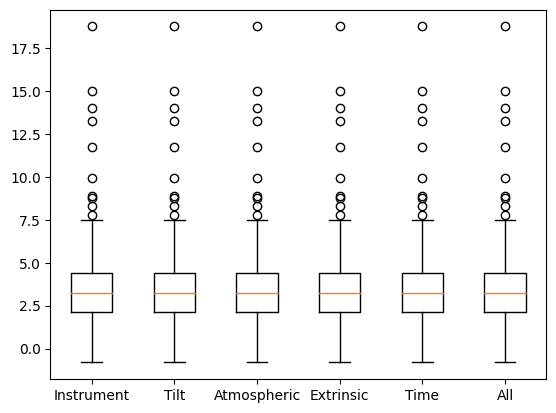

In [28]:
fig, ax = plt.subplots()
x_pos = np.arange(len(models))
y_pos = [df.perimeter for df in concat_dists.values()]

ax.boxplot(y_pos, positions=x_pos)
ax.set_xticks(x_pos)
ax.set_xticklabels(models)

In [ ]:
pose_covariance = [f"Sp{i}" for i in range(9)]
poscovs = {
    l: df[pose_covariance].copy()
    for l, df in concat_dists.items()
}
for l, df in poscovs.items():
    df["sumcov"] = df.Sp0 + df.Sp4 + df.Sp8
    df["covxyz"] = np.sqrt(df.sumcov)
    spdf = df[pose_covariance].copy().to_numpy()
    mats = [spdf[i, :].reshape((3, 3)) for i in range(spdf.shape[0])]
    df["frob"] = 1_000_000 * pd.Series(
        [
            np.linalg.norm(spdf[i, :].reshape((3, 3)), ord="fro")
            for i in range(spdf.shape[0])
        ]
    )

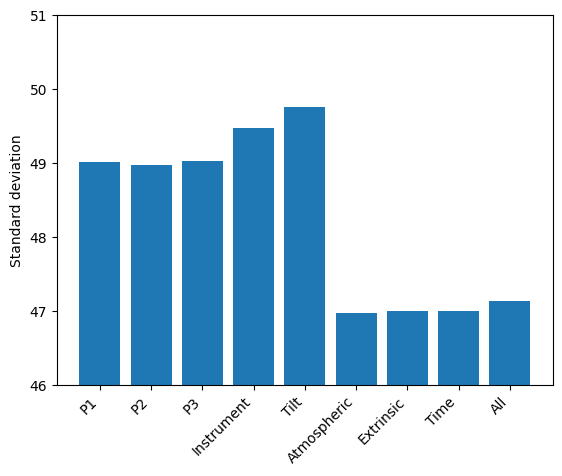

In [6]:

stds = {lab: np.std(pt.T, dtype=np.float64) for lab, pt in poses.items()}
fig, ax = plt.subplots()
labs = [*stds.keys()]
labstd = [stds[lab] for lab in labs]

x_pos = np.arange(len(labs))
ax.bar(x_pos, labstd)
ax.set_xticks(x_pos)
ax.set_xticklabels(labs, rotation=45, ha="right")
ax.set_ylabel("Standard deviation")
ax.set_ylim((46, 51))

plt.show()

In [7]:
pose_covariance = [f"Sp{i}" for i in range(9)]
poscovs = {
    l: df[pose_covariance].dropna().copy()
    for l, df in concat_dfs.items()
    if l in models
}
for l, df in poscovs.items():
    df["sumcov"] = df.Sp0 + df.Sp4 + df.Sp8
    df["covxyz"] = np.sqrt(df.sumcov)
    spdf = df[pose_covariance].copy().to_numpy()
    mats = [spdf[i, :].reshape((3, 3)) for i in range(spdf.shape[0])]
    df["frob"] = 1_000_000 * pd.Series(
        [
            np.linalg.norm(spdf[i, :].reshape((3, 3)), ord="fro")
            for i in range(spdf.shape[0])
        ]
    )


Median
[556028.3623568146, 532197.5658740661, 546968.6665174371, 555923.8014365144, 534328.2423450203, 594882.3675881401]
stddev
[786557.7493797118, 1674823.9588093294, 229042.20535665043, 234408.39738497327, 786294.6051491086, 179711.65410177244]


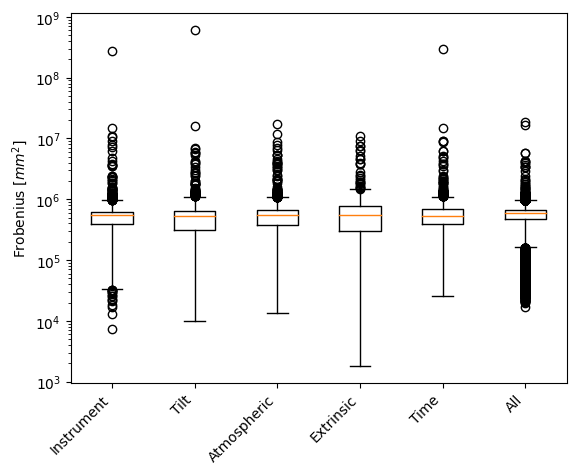

In [8]:
fig, ax = plt.subplots()
labs = [p for p in poscovs.keys() if p in models]
frobenius = [poscovs[lab].frob for lab in labs]
medians = [cov.median() for cov in frobenius]
stdev = [cov.std() for cov in frobenius]
print("Median", medians, "stddev", stdev, sep="\n")

x_pos = np.arange(len(labs))
ax.boxplot(frobenius, positions=x_pos)
ax.set_xticks(x_pos)
ax.set_xticklabels(labs, rotation=45, ha="right")
# ax.set_ylabel("Covariances $\sum_{i=x,y,z} \sigma_{ii}^2$")
ax.set_ylabel("Frobenius $[mm^2]$")
# ax.set_ylim((0, 5))
ax.set_yscale("log")

plt.show()

Median
[0.7964670893993191, 0.7976762347468211, 0.842292827029434, 0.7817120447034015, 0.7821390013549216, 0.8287737864802869]
stddev
[0.18221512999520312, 0.18365215642472524, 0.20375657901807084, 0.20190402219326858, 0.16039718097695077, 0.12778010630239078]


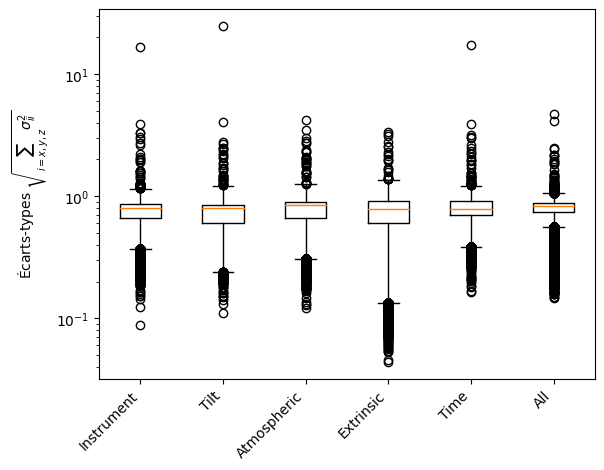

In [9]:
fig, ax = plt.subplots()
labs = [p for p in poscovs.keys() if p in models]
covariances = [poscovs[lab].covxyz for lab in labs]
medians = [cov.median() for cov in covariances]
stdev = [cov.std() for cov in covariances]
print("Median", medians, "stddev", stdev, sep="\n")

x_pos = np.arange(len(labs))
ax.boxplot(covariances, positions=x_pos)
ax.set_xticks(x_pos)
ax.set_xticklabels(labs, rotation=45, ha="right")
# ax.set_ylabel("Covariances $\sum_{i=x,y,z} \sigma_{ii}^2$")
ax.set_ylabel("Écarts-types $\sqrt{\sum_{i=x,y,z} \sigma_{ii}^2}$")
# ax.set_ylim((0, 5))
ax.set_yscale("log")

plt.show()

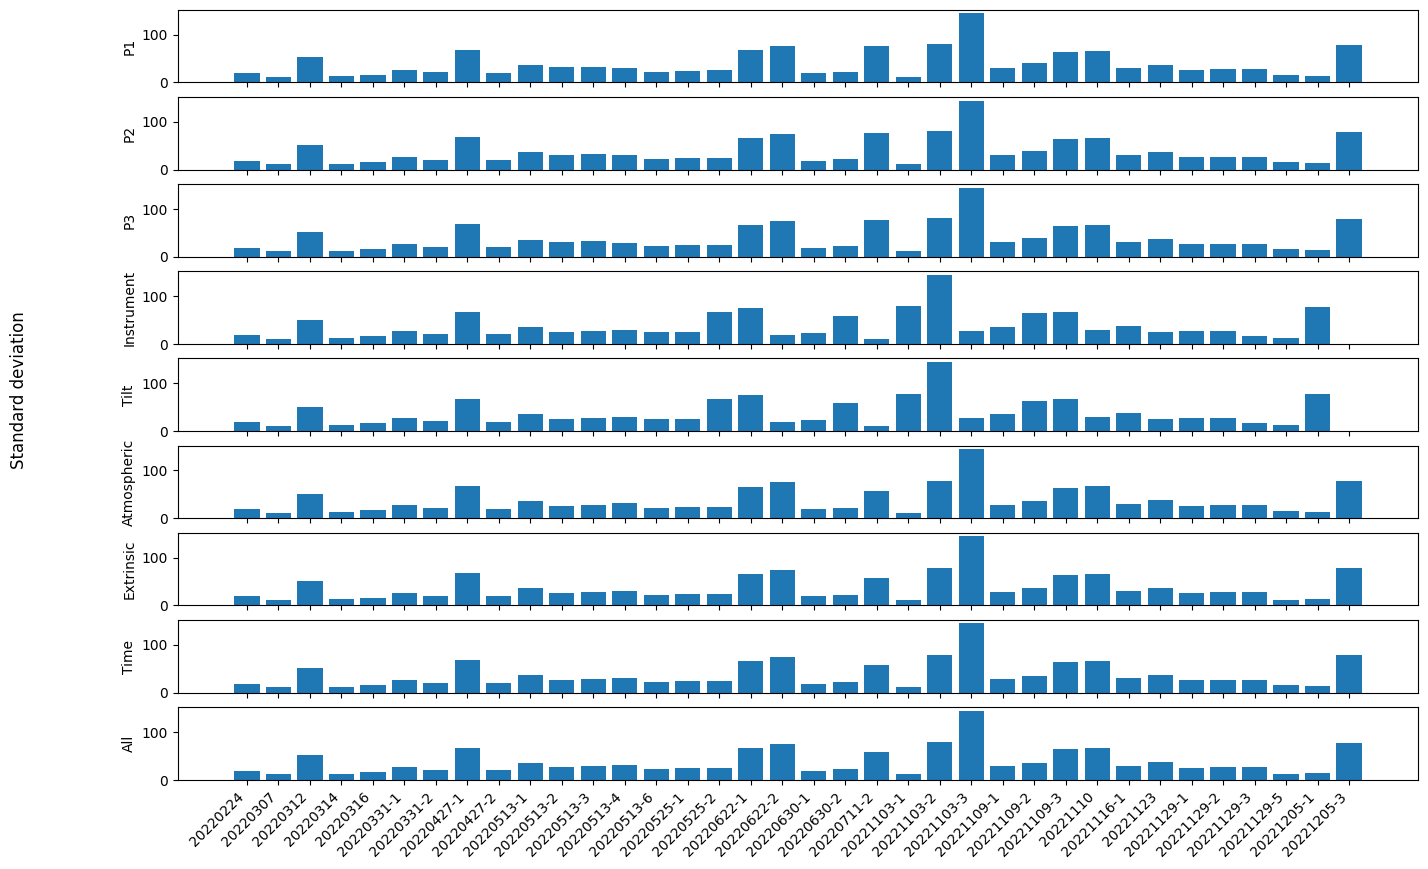

In [10]:
dates = [p.stem for p in experiment_paths]
fig, subfigs = plt.subplots(nrows=len(orig_dfs.keys()), figsize=(16,10), sharex=True, sharey=True)
for (mname, mdfs), ax in zip(orig_dfs.items(), subfigs.reshape(-1)):
    labels = [*mdfs.keys()]
    x_pos = np.arange(len(labels))
    stddevs = [np.std(df[pose_mean].copy().to_numpy().T, dtype=np.float64) for df in mdfs.values()]
    ax.bar(x_pos, stddevs)
    ax.set_xticks(x_pos)
    ax.set_ylabel(mname)
    # ax.set_title(mname)
    # ax.set_ylim((46, 51))
subfigs[-1].set_xticks(x_pos)
subfigs[-1].set_xticklabels(labels, rotation=45, ha="right")
fig.supylabel("Standard deviation")
plt.show()
    

In [11]:
axfrobs = []
for mname in models:
    mdfs = orig_dfs[mname]
    posecovs = [df[pose_covariance].copy().to_numpy() for df in mdfs.values()]
    frobs = [
        np.array(
            [
                np.linalg.norm(spdf[i, :].reshape((3, 3)), ord="fro")
                for i in range(spdf.shape[0])
            ]
        )
        for spdf in posecovs
    ]
    axfrobs.append(frobs)

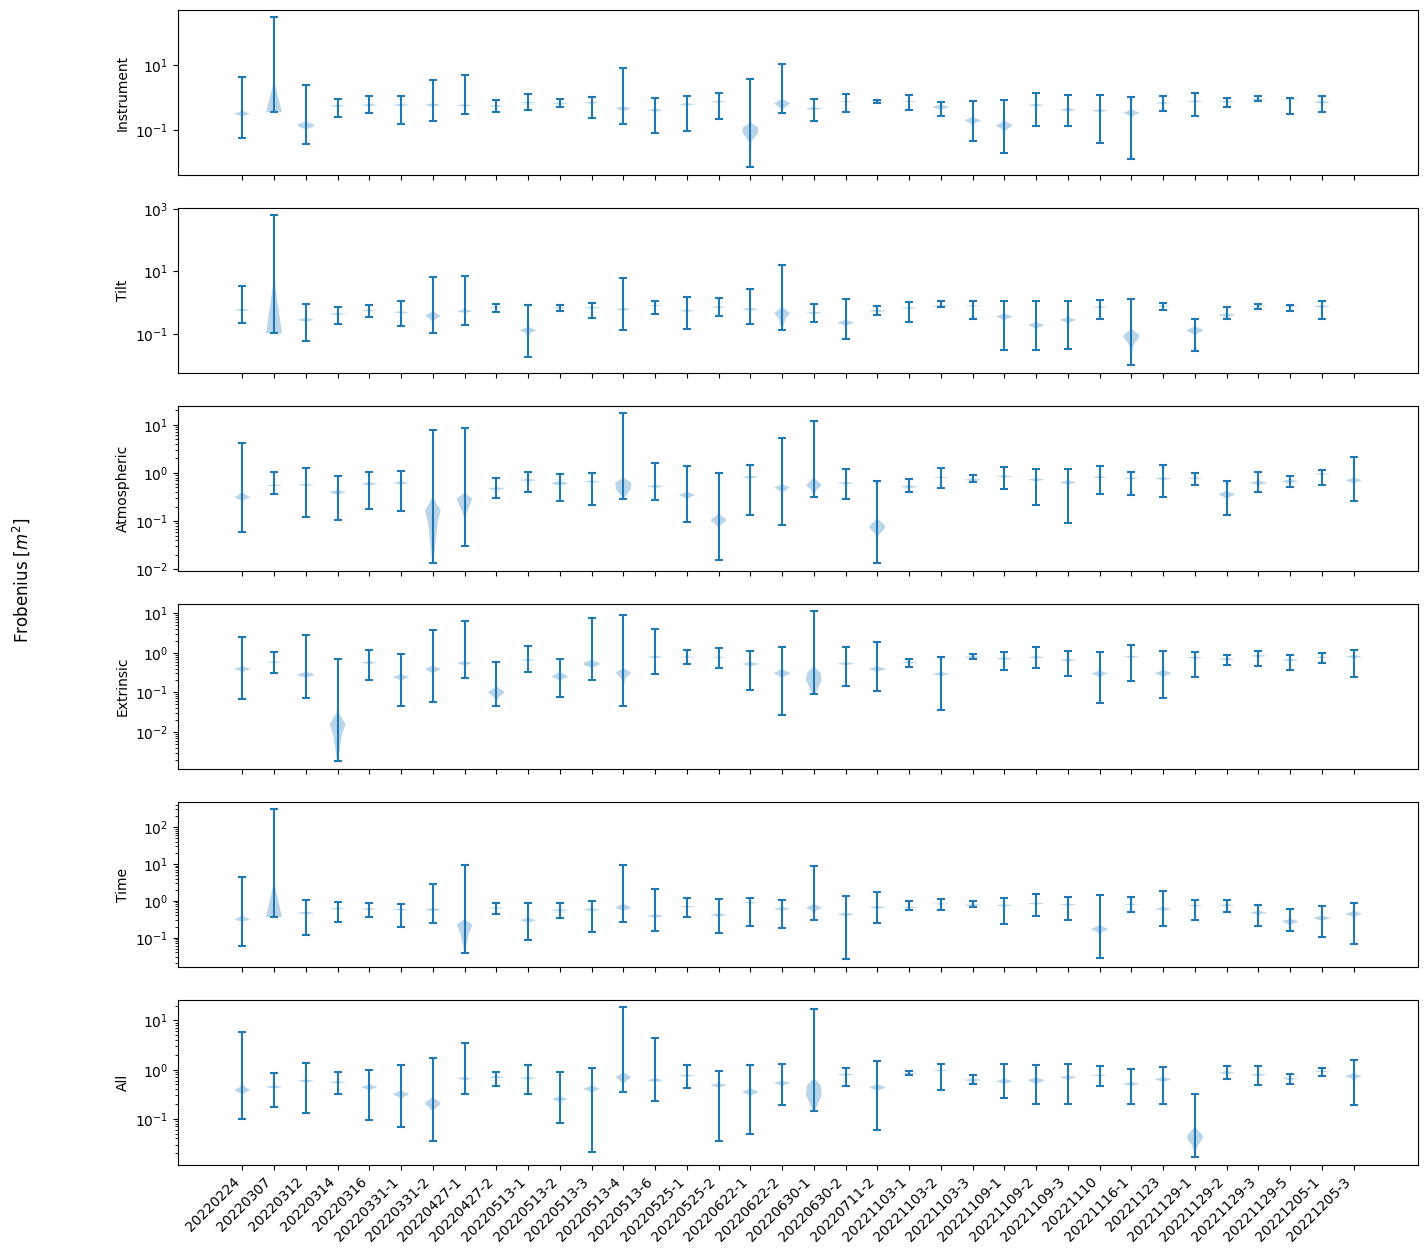

In [12]:
dates = [p.stem for p in experiment_paths]
fig, subfigs = plt.subplots(
    nrows=len(models), figsize=(16, 15), sharex=True
)
for mname, frobs, ax in zip(models, axfrobs, subfigs.reshape(-1)):
    mdfs = orig_dfs[mname]
    labels = [*mdfs.keys()]
    x_pos = np.arange(len(labels))
    ax.violinplot(frobs, positions=x_pos)
    ax.set_ylabel(mname)
    # ax.set_ylim((0,1))
    ax.set_yscale("log")
    # ax.set_title(mname)
    # ax.set_ylim((46, 51))
subfigs[-1].set_xticks(x_pos)
subfigs[-1].set_xticklabels(labels, rotation=45, ha="right")
fig.supylabel("Frobenius [$m^2$]")
plt.show()
